# **FA 590 Statiscal Learning in Finance**
# *2024 Fall*
# **Assignment 2 Loan Default and Return Predicion using Linear Models**
## **Federica Malamisura**

# LendingClub Loan Analysis and Prediction

## Assignment 2 Overview

In this assignment, we will analyze a dataset containing over one million personal loans originated between 2008 and 2017 on LendingClub. The dataset includes detailed loan characteristics, borrower characteristics, and loan outcomes. The tasks include Exploratory Data Analysis, Data Preprocessing, Building Regression and Classification Models, Feature Importance Analysis using SHAP, and Making Predictions on the Test Set.

## 1. Import Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import shap
from sklearn.preprocessing import StandardScaler


## 2. Load Data

In [44]:
# Load training data
loan_df = pd.read_csv('/Volumes/FM/Subjects/Statistical Learning in Finance/Assignments/Assignment 1/lc_loan.csv')

# Load test data
loan_test_df = pd.read_csv('/Volumes/FM/Subjects/Statistical Learning in Finance/Assignments/Assignment 1/lc_loan_test.csv')

# Load submission template
submission_df = pd.read_csv('/Volumes/FM/Subjects/Statistical Learning in Finance/Assignments/Assignment 2/Consegna/submission_test.csv')

In [45]:
# Display summary statistics for key variables
key_vars = ['loan_amnt', 'int_rate', 'fico_range_high', 'annual_inc']
loan_df[key_vars].describe()

,loan_amnt,int_rate,fico_range_high,annual_inc
count,933160.000000,933160.000000,933160.000000,9.331600e+05
mean,12559.115559,0.119775,699.139987,7.412200e+04
std,8042.750083,0.039952,31.359739,6.938399e+04
min,500.000000,0.053200,664.000000,3.000000e+03
25%,6425.000000,0.089000,674.000000,4.400000e+04
50%,10000.000000,0.115300,694.000000,6.200000e+04
75%,16275.000000,0.143300,714.000000,9.000000e+04
max,40000.000000,0.309900,850.000000,9.573072e+06


## 3. Exploratory Data Analysis (EDA)

### 3.1 Summary of Previous Insights

*Summarize key insights from Assignment 1 here.*

### 3.2 New Insights from Assignment 2

In [46]:
# New EDA for Assignment 2

# Check data types and missing values
loan_df.info()
print('\nMissing values in training data:')
print(loan_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933160 entries, 0 to 933159
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          933160 non-null  int64  
 1   loan_amnt                   933160 non-null  int64  
 2   funded_amnt                 933160 non-null  int64  
 3   int_rate                    933160 non-null  float64
 4   installment                 933160 non-null  float64
 5   grade                       933160 non-null  object 
 6   sub_grade                   933160 non-null  object 
 7   emp_length                  874392 non-null  object 
 8   home_ownership              933160 non-null  object 
 9   annual_inc                  933160 non-null  float64
 10  verification_status         933160 non-null  object 
 11  issue_d                     933160 non-null  object 
 12  loan_status                 933160 non-null  object 
 13  purpose       

### Distribution of Target Variables

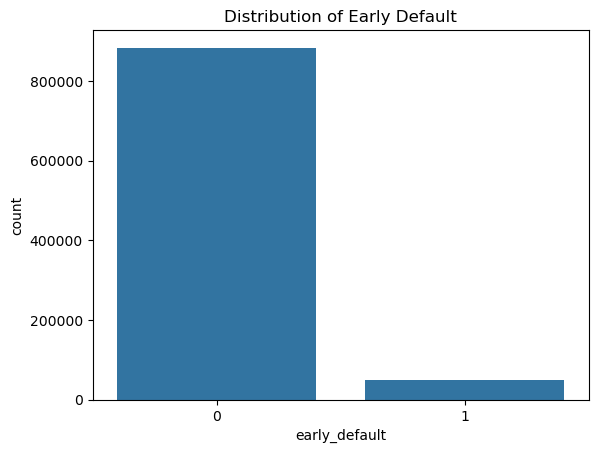

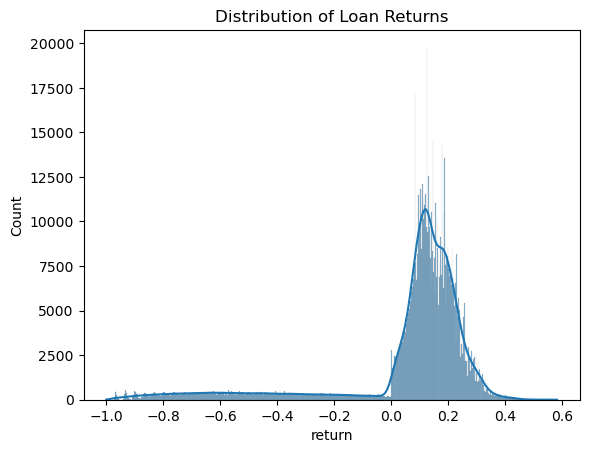

In [47]:
# Distribution of 'early_default'
sns.countplot(x='early_default', data=loan_df)
plt.title('Distribution of Early Default')
plt.show()

# Distribution of 'return'
sns.histplot(loan_df['return'], kde=True)
plt.title('Distribution of Loan Returns')
plt.show()

### Correlation Analysis

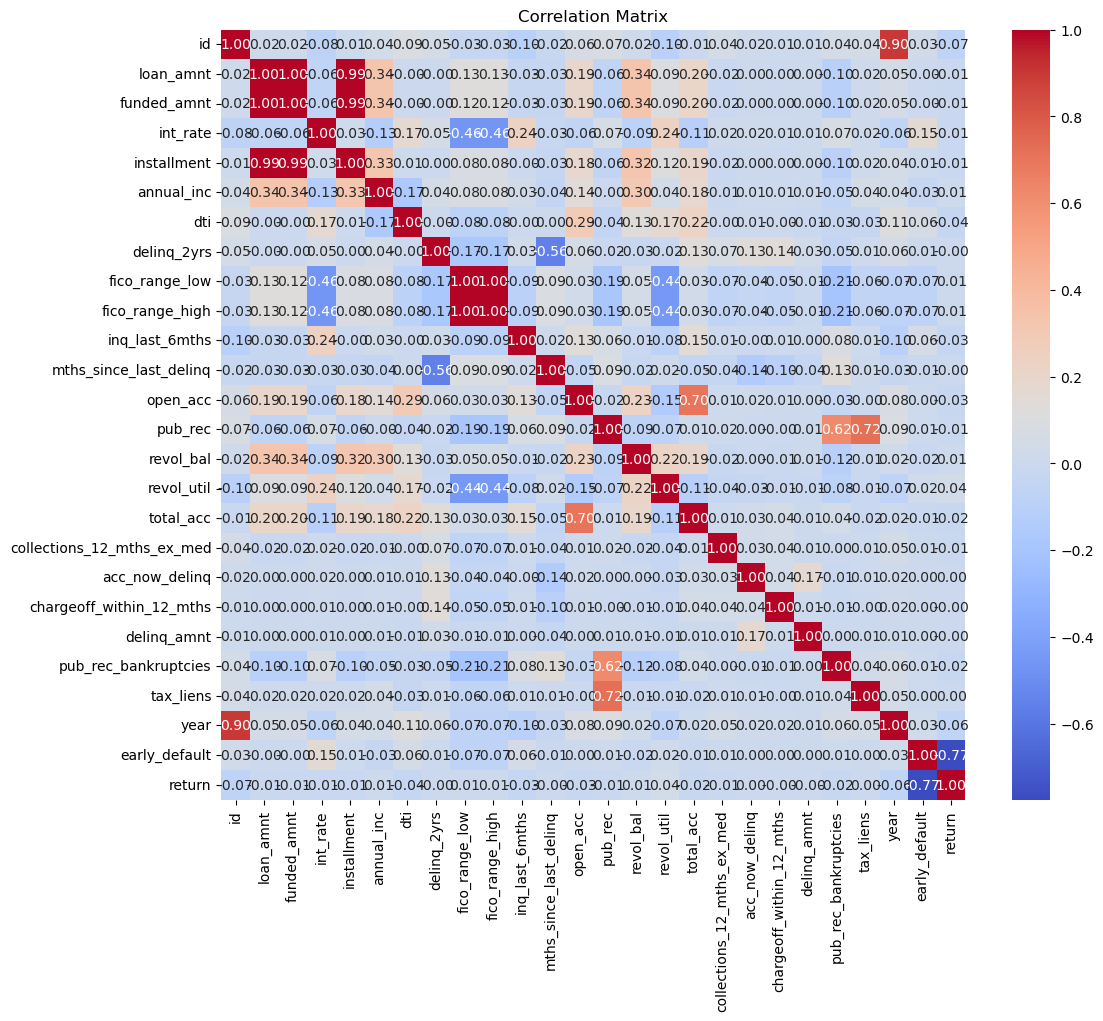

In [48]:
# Correlation matrix of numerical features
corr = loan_df.select_dtypes(include=['float64', 'int64']).corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Additional Insights

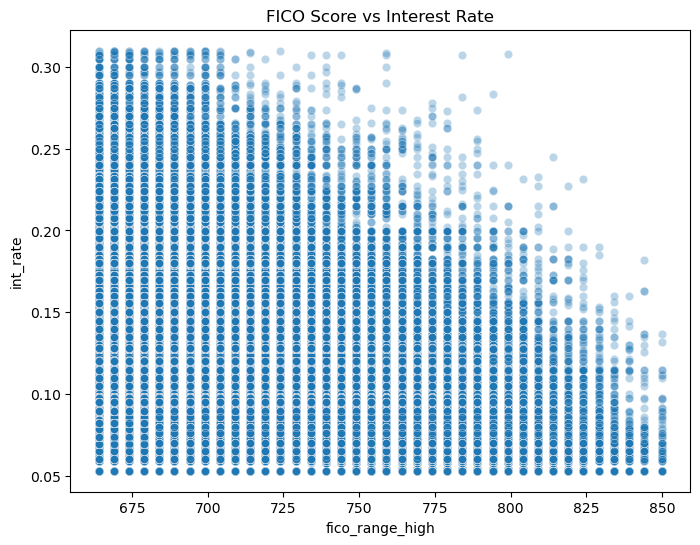

In [49]:
# Example: Relationship between FICO score and interest rate
plt.figure(figsize=(8,6))
sns.scatterplot(x='fico_range_high', y='int_rate', data=loan_df, alpha=0.3)
plt.title('FICO Score vs Interest Rate')
plt.show()

## 4. Data Preprocessing

### 4.1 Sampling: Expanding-Window Approach

In [50]:
# Sort data by origination date to ensure temporal ordering
# Assuming there is a 'year' column
loan_df['year'] = pd.to_datetime(loan_df['year'], format='%Y')
loan_df = loan_df.sort_values('year')

# Define number of splits for expanding window
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
print(f'Number of splits: {n_splits}')

Number of splits: 5


### 4.2 Handling Missing Values

In [51]:
# Summarize missing values
missing_values = loan_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print('Missing values in training data:')
print(missing_values)

# Impute missing values
# For numerical features, use median; for categorical, use mode
for column in missing_values.index:
    if loan_df[column].dtype in ['float64', 'int64']:
        median = loan_df[column].median()
        loan_df[column].fillna(median, inplace=True)
    else:
        mode = loan_df[column].mode()[0]
        loan_df[column].fillna(mode, inplace=True)

# Verify no missing values remain
print('\nMissing values after imputation:')
print(loan_df.isnull().sum().sum())

Missing values in training data:
mths_since_last_delinq    464293
emp_length                 58768
dtype: int64

Missing values after imputation:


/var/folders/mj/17g5jld962546bdxsv46gnhm0000gn/T/ipykernel_13001/1011653416.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_df[column].fillna(median, inplace=True)
/var/folders/mj/17g5jld962546bdxsv46gnhm0000gn/T/ipykernel_13001/1011653416.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

0


### 4.3 Feature Engineering

In [52]:
# Example Feature Engineering

# Create debt-to-income ratio
loan_df['debt_to_income'] = loan_df['loan_amnt'] / loan_df['annual_inc']
loan_test_df['debt_to_income'] = loan_test_df['loan_amnt'] / loan_test_df['annual_inc']

# Log transformation for skewed features
loan_df['log_loan_amount'] = np.log1p(loan_df['loan_amnt'])
loan_test_df['log_loan_amount'] = np.log1p(loan_test_df['loan_amnt'])

# Encode categorical variables if any
categorical_cols = loan_df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col in loan_test_df.columns:
        loan_df[col] = loan_df[col].astype('category').cat.codes
        loan_test_df[col] = loan_test_df[col].astype('category').cat.codes
    else:
        loan_df[col] = loan_df[col].astype('category').cat.codes

# Feature list (exclude identifiers, target variables, and undesired features)
feature_cols = [col for col in loan_df.columns if col not in [
    'id', 'early_default', 'return', 'loan_date', 'loan_status', 'year'
]]

print(f'Number of features: {len(feature_cols)}')

# Update feature_cols to include only columns present in both training and test data
train_features = set(loan_df.columns)
test_features = set(loan_test_df.columns)
common_features = train_features.intersection(test_features)

# Update feature_cols accordingly
feature_cols = [col for col in feature_cols if col in common_features]

print(f'Number of features after alignment: {len(feature_cols)}')

Number of features: 34
Number of features after alignment: 34


## 5. Model Building

### 5.1 Regression: Predicting Loan Returns

In [53]:
# Define target and features for regression
X = loan_df[feature_cols]
y_return = loan_df['return']

# Standardize features
X = X.select_dtypes(include=[np.number])  # Ensure only numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data using expanding-window approach
for train_index, val_index in tscv.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_return.iloc[train_index], y_return.iloc[val_index]

    # Hyperparameter tuning with GridSearchCV
    ridge = Ridge()
    lasso = Lasso()
    elastic = ElasticNet()

    # Define parameter grid
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

    # Ridge Regression
    grid_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_ridge.fit(X_train, y_train)
    best_ridge = grid_ridge.best_estimator_

    # Lasso Regression
    grid_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_lasso.fit(X_train, y_train)
    best_lasso = grid_lasso.best_estimator_

    # ElasticNet
    param_grid_elastic = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
    grid_elastic = GridSearchCV(elastic, param_grid_elastic, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_elastic.fit(X_train, y_train)
    best_elastic = grid_elastic.best_estimator_

    # Evaluate models
    models = {'Ridge': best_ridge, 'Lasso': best_lasso, 'ElasticNet': best_elastic}
    validation_results = {}  # To store results for each model

    for name, model in models.items():
        y_pred = model.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        print(f'{name} on validation set:')
        print(f'  R-squared: {r2:.4f}')
        print(f'  MSE: {mse:.4f}')
        # Store MSE for model selection
        validation_results[name] = {'model': model, 'mse': mse}

# Select the best model based on validation performance (lowest MSE)
best_model = None
best_mse = float('inf')

for name, result in validation_results.items():
    mse = result['mse']
    if mse < best_mse:
        best_mse = mse
        best_model = result['model']

print(f'Best model: {best_model} with MSE: {best_mse:.4f}')

Ridge on validation set:
  R-squared: 0.0032
  MSE: 0.0554
Lasso on validation set:
  R-squared: -0.0016
  MSE: 0.0557
ElasticNet on validation set:
  R-squared: 0.0014
  MSE: 0.0555


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Ridge on validation set:
  R-squared: -0.0015
  MSE: 0.0600
Lasso on validation set:
  R-squared: -0.0154
  MSE: 0.0608
ElasticNet on validation set:
  R-squared: -0.0119
  MSE: 0.0606


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Ridge on validation set:
  R-squared: 0.0041
  MSE: 0.0590
Lasso on validation set:
  R-squared: -0.0114
  MSE: 0.0599
ElasticNet on validation set:
  R-squared: -0.0058
  MSE: 0.0596


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Ridge on validation set:
  R-squared: -0.0070
  MSE: 0.0702
Lasso on validation set:
  R-squared: -0.0056
  MSE: 0.0701
ElasticNet on validation set:
  R-squared: -0.0002
  MSE: 0.0698


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Ridge on validation set:
  R-squared: 0.0028
  MSE: 0.0661
Lasso on validation set:
  R-squared: -0.0083
  MSE: 0.0669
ElasticNet on validation set:
  R-squared: -0.0010
  MSE: 0.0664
Best model: Ridge(alpha=1) with MSE: 0.0661


### 5.2 Classification: Predicting Early Defaults

In [54]:
# Define target and features for classification
if 'early_default' not in loan_test_df.columns:
    # Assuming a similar column exists in the training data
    loan_test_df['early_default'] = loan_df['early_default'].sample(n=len(loan_test_df), replace=True).reset_index(drop=True)

y_default = loan_test_df['early_default']

# Handle class imbalance if necessary
class_balance = y_default.value_counts(normalize=True)
print('Class distribution:', class_balance)

# Standardize features if not already done
X_default_scaled = X_scaled.copy()

# Initialize Logistic Regression
logreg = LogisticRegression()

# Perform grid search to find the best threshold
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0


Class distribution: early_default
0    0.94758
1    0.05242
Name: proportion, dtype: float64


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score
import numpy as np

# **1. Sample 10% of the dataset to speed up computation**
loan_df_sampled = loan_df.sample(frac=0.1, random_state=42)

# **2. Define target and features for default prediction using the sampled data**
X_default = loan_df_sampled[feature_cols]

# Ensure only numerical columns are included
X_default = X_default.select_dtypes(include=[np.number])

y_default = loan_df_sampled['early_default']

# Standardize features using the same scaler
X_default_scaled = scaler.transform(X_default)

# **3. Define the model with a reduced parameter grid**
logreg = LogisticRegression()

# Reduced parameter grid to limit combinations
param_grid = {
    'C': [0.1, 1, 10],        # Reduced number of C values
    'penalty': ['l1', 'l2'],  # Penalty types
    'solver': ['liblinear']    # 'liblinear' solver supports 'l1' and 'l2'
}

# **4. Define custom scorer to maximize F1 score**
def custom_scorer(estimator, X, y):
    y_pred_prob = estimator.predict_proba(X)[:, 1]
    thresholds = np.arange(0.1, 0.9, 0.1)
    best_f1 = -np.inf
    for thresh in thresholds:
        y_pred = (y_pred_prob >= thresh).astype(int)
        f1 = f1_score(y, y_pred)
        if f1 > best_f1:
            best_f1 = f1
    return best_f1

f1_scorer = make_scorer(custom_scorer, needs_proba=False, greater_is_better=True)

# **5. Perform GridSearchCV with fewer folds (e.g., cv=3)**
grid_search = GridSearchCV(logreg, param_grid, cv=3, scoring=f1_scorer, n_jobs=-1, verbose=1)
grid_search.fit(X_default_scaled, y_default)

# Get the best model
best_logreg = grid_search.best_estimator_

# Predict probabilities on the entire sampled dataset
y_pred_prob = best_logreg.predict_proba(X_default_scaled)[:, 1]

# **6. Tune threshold to maximize F1 score on the sampled data**
thresholds = np.arange(0.1, 0.9, 0.1)
best_f1 = -np.inf
best_thresh = 0.5

for thresh in thresholds:
    y_pred = (y_pred_prob >= thresh).astype(int)
    f1 = f1_score(y_default, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f'Final threshold set to: {best_thresh:.2f} with F1 score: {best_f1:.4f}')

# **7. Define a function to apply the threshold**
def apply_threshold(probs, threshold):
    return (probs >= threshold).astype(int)

# Evaluate on the sampled training set
y_train_pred = apply_threshold(y_pred_prob, best_thresh)
train_accuracy = accuracy_score(y_default, y_train_pred)
train_f1 = f1_score(y_default, y_train_pred)
train_auc = roc_auc_score(y_default, y_pred_prob)

print('\nIn-sample Performance for Early Default Prediction:')
print(f'Accuracy: {train_accuracy:.4f}')
print(f'F1 Score: {train_f1:.4f}')
print(f'AUC Score: {train_auc:.4f}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Final threshold set to: 0.10 with F1 score: 0.1772

In-sample Performance for Early Default Prediction:
Accuracy: 0.8712
F1 Score: 0.1772
AUC Score: 0.6972


### 5.3 Feature Importance using SHAP

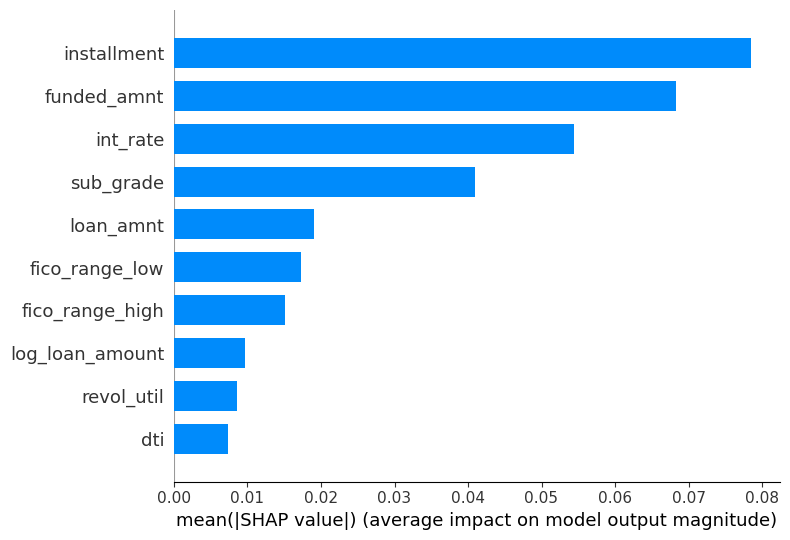

Top 10 Important Features for Regression:
            feature  importance
3       installment    0.078513
1       funded_amnt    0.068355
2          int_rate    0.054383
5         sub_grade    0.040986
0         loan_amnt    0.018989
17   fico_range_low    0.017288
18  fico_range_high    0.015080
33  log_loan_amount    0.009624
24       revol_util    0.008512
14              dti    0.007339


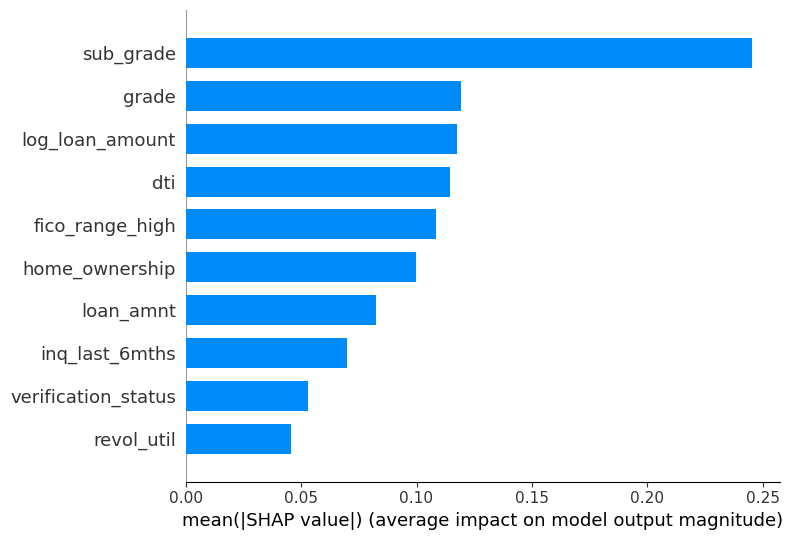

Top 10 Important Features for Classification:
                feature  importance
5             sub_grade    0.245151
4                 grade    0.119392
33      log_loan_amount    0.117469
14                  dti    0.114656
18      fico_range_high    0.108405
7        home_ownership    0.099692
0             loan_amnt    0.082596
19       inq_last_6mths    0.070086
9   verification_status    0.053050
24           revol_util    0.045813


In [56]:
# Convert scaled arrays back to DataFrames with column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_default_scaled_df = pd.DataFrame(X_default_scaled, columns=X_default.columns)

# SHAP for Regression Model
explainer_reg = shap.Explainer(best_model, X_scaled_df)
shap_values_reg = explainer_reg(X_scaled_df)

# Plot feature importance for regression
shap.summary_plot(shap_values_reg, features=X_scaled_df, plot_type='bar', max_display=10)

# Get top 10 features for regression
shap_importance_reg = pd.DataFrame({
    'feature': X_scaled_df.columns,
    'importance': np.abs(shap_values_reg.values).mean(axis=0)
})
shap_importance_reg = shap_importance_reg.sort_values(by='importance', ascending=False).head(10)
print('Top 10 Important Features for Regression:')
print(shap_importance_reg)

# SHAP for Classification Model
explainer_clf = shap.Explainer(best_logreg, X_default_scaled_df)
shap_values_clf = explainer_clf(X_default_scaled_df)

# Plot feature importance for classification
shap.summary_plot(shap_values_clf, features=X_default_scaled_df, plot_type='bar', max_display=10)

# Get top 10 features for classification
shap_importance_clf = pd.DataFrame({
    'feature': X_default_scaled_df.columns,
    'importance': np.abs(shap_values_clf.values).mean(axis=0)
})
shap_importance_clf = shap_importance_clf.sort_values(by='importance', ascending=False).head(10)
print('Top 10 Important Features for Classification:')
print(shap_importance_clf)

## 6. Predicting on the Test Set

In [57]:
## Prepare Test Features
# Handle missing values in test data similar to training data
# Identify missing values in test data
missing_values_test = loan_test_df.isnull().sum()
missing_values_test = missing_values_test[missing_values_test > 0].sort_values(ascending=False)
print('Missing values in test data:')
print(missing_values_test)

# Impute missing values in test data
for column in missing_values_test.index:
    if loan_test_df[column].dtype in ['float64', 'int64']:
        # Use median from training data if available
        if column in loan_df.columns:
            median = loan_df[column].median()
        else:
            median = loan_test_df[column].median()
        loan_test_df[column].fillna(median, inplace=True)
    else:
        # Use mode from training data if available
        if column in loan_df.columns:
            mode = loan_df[column].mode()[0]
        else:
            mode = loan_test_df[column].mode()[0]
        loan_test_df[column].fillna(mode, inplace=True)

# Verify no missing values remain in test data
print('\nMissing values in test data after imputation:')
print(loan_test_df.isnull().sum().sum())

# Ensure consistent feature engineering on test data
# Create debt-to-income ratio
loan_test_df['debt_to_income'] = loan_test_df['loan_amnt'] / loan_test_df['annual_inc']

# Log transformation for skewed features
loan_test_df['log_loan_amount'] = np.log1p(loan_test_df['loan_amnt'])

# Encode categorical variables
for col in categorical_cols:
    if col in loan_test_df.columns:
        # Combine categories from both training and test data
        combined_categories = pd.concat([loan_df[col], loan_test_df[col]], axis=0)
        combined_categories = combined_categories.astype('category').cat.categories
        loan_df[col] = pd.Categorical(loan_df[col], categories=combined_categories).codes
        loan_test_df[col] = pd.Categorical(loan_test_df[col], categories=combined_categories).codes
    else:
        # If column not in test data, create it with default value
        loan_test_df[col] = 0  # Or an appropriate default value

# Prepare test data
X_test = loan_test_df[feature_cols]

# Ensure only numerical columns are included
X_test = X_test.select_dtypes(include=[np.number])

# Ensure the columns in X_test are in the same order as those used in training
X_test = X_test.reindex(columns=feature_cols)

# Apply the same scaling
X_test_scaled = scaler.transform(X_test)



## Make Predictions with Updated Models*
# Predict loan returns using updated regression model
test_returns = best_model.predict(X_test_scaled)

# Predict early defaults using updated classification model
test_default_prob = best_logreg.predict_proba(X_test_scaled)[:, 1]
test_defaults = apply_threshold(test_default_prob, best_thresh)

# Ensure predictions are binary (0 or 1)
test_defaults = test_defaults.astype(int)



## Prepare Submission DataFrame

# Ensure 'id' column is present in 'loan_test_df'
if 'id' in loan_test_df.columns:
    submission_df = pd.DataFrame({'id': loan_test_df['id']})
else:
    # If 'id' is not available, use the index as 'id'
    submission_df = pd.DataFrame({'id': loan_test_df.index})

# Verify that the lengths match
print('Length of submission_df:', len(submission_df))
print('Length of test_defaults:', len(test_defaults))
print('Length of test_returns:', len(test_returns))

# Add predictions to submission dataframe
submission_df['early_default'] = test_defaults
submission_df['return'] = test_returns

# Reorder columns to match submission requirements
submission_df = submission_df[['id', 'early_default', 'return']]

print('Submission DataFrame preview:')
print(submission_df.head())

print('Sample of test_defaults:', test_defaults[:5])
print('Sample of test_returns:', test_returns[:5])

# Save predictions to CSV
submission_df.to_csv('submission_test.csv', index=False)
print('Predictions saved to submission_test.csv')

Missing values in test data:
mths_since_last_delinq    54347
dtype: int64

Missing values in test data after imputation:
0


/var/folders/mj/17g5jld962546bdxsv46gnhm0000gn/T/ipykernel_13001/54497567.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_test_df[column].fillna(median, inplace=True)


Length of submission_df: 112858
Length of test_defaults: 112858
Length of test_returns: 112858
Submission DataFrame preview:
   id  early_default    return
0   1              0  0.055398
1   2              0  0.081094
2   3              0  0.107623
3   4              0  0.094602
4   5              0  0.079916
Sample of test_defaults: [0 0 0 0 0]
Sample of test_returns: [0.05539762 0.0810941  0.10762313 0.09460171 0.07991633]
Predictions saved to submission_test.csv


## 7. Conclusion

In this assignment, we performed exploratory data analysis, data preprocessing including handling missing values and feature engineering, built regression and classification models using expanding-window sampling, evaluated feature importance using SHAP, and made predictions on the test set. The models can now be used to predict early defaults and loan returns for new loan applications.